In [1]:
import obsidian
obsidian.__version__

c:\Users\kevin\miniconda3\envs\obsidian-pypi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.7.10'

In [2]:
import pandas as pd
import plotly.express as px

In [3]:
from obsidian import Campaign, Target, ParamSpace, BayesianOptimizer
from obsidian.parameters import Param_Categorical, Param_Ordinal, Param_Continuous

### Set up parameter space and initialize a design

In [4]:
params = [
    Param_Continuous('Temperature', -10, 30),
    Param_Continuous('Concentration', 10, 150),
    Param_Continuous('Enzyme', 0.01, 0.30),
    Param_Categorical('Variant', ['MRK001', 'MRK002', 'MRK003']),
    Param_Ordinal('Stir Rate', ['Low', 'Medium', 'High']),
    ]

X_space = ParamSpace(params)
target = Target('Yield', aim='max')
campaign = Campaign(X_space, target, seed=0)
X0 = campaign.designer.initialize(10, 'LHS')

X0

,Temperature,Concentration,Enzyme,Variant,Stir Rate
0,8.0,17.0,0.1405,MRK001,Medium
1,12.0,143.0,0.1695,MRK003,Medium
2,4.0,101.0,0.2855,MRK002,High
3,28.0,87.0,0.1115,MRK002,Low
4,-4.0,115.0,0.2275,MRK001,Low
5,-8.0,73.0,0.0825,MRK002,Medium
6,20.0,129.0,0.0535,MRK001,High
7,24.0,31.0,0.2565,MRK002,Medium
8,16.0,59.0,0.1985,MRK003,High
9,0.0,45.0,0.0245,MRK003,Low


### Collect results (e.g. from a simulation)

In [5]:
from obsidian.experiment import Simulator
from obsidian.experiment.benchmark import shifted_parab

simulator = Simulator(X_space, shifted_parab, name='Yield', eps=0.05)
y0 = simulator.simulate(X0)
Z0 = pd.concat([X0, y0], axis=1)

Z0

,Temperature,Concentration,Enzyme,Variant,Stir Rate,Yield
0,8.0,17.0,0.1405,MRK001,Medium,92.339807
1,12.0,143.0,0.1695,MRK003,Medium,44.280131
2,4.0,101.0,0.2855,MRK002,High,46.270422
3,28.0,87.0,0.1115,MRK002,Low,60.288919
4,-4.0,115.0,0.2275,MRK001,Low,63.082417
5,-8.0,73.0,0.0825,MRK002,Medium,86.196333
6,20.0,129.0,0.0535,MRK001,High,47.625034
7,24.0,31.0,0.2565,MRK002,Medium,48.966143
8,16.0,59.0,0.1985,MRK003,High,49.876574
9,0.0,45.0,0.0245,MRK003,Low,81.228810


<Axes: xlabel='Temperature', ylabel='Yield'>

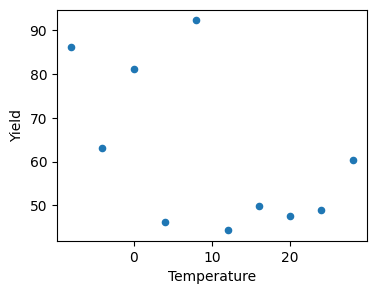

In [6]:
Z0.plot(x='Temperature', y='Yield', kind='scatter', figsize=(4,3))

### Create a campaign to track optimization

### Fit the optimizer

In [7]:
campaign.add_data(Z0)
campaign.data.sample(5)

,Temperature,Concentration,Enzyme,Variant,Stir Rate,Yield,Iteration
Observation ID,,,,,,,
5,-8.0,73.0,0.0825,MRK002,Medium,86.196333,0
2,4.0,101.0,0.2855,MRK002,High,46.270422,0
3,28.0,87.0,0.1115,MRK002,Low,60.288919,0
4,-4.0,115.0,0.2275,MRK001,Low,63.082417,0
1,12.0,143.0,0.1695,MRK003,Medium,44.280131,0


In [8]:
campaign.fit()

GP model has been fit                       to data with a train-score of: 1 for response: Yield


### Make new experiment suggestions

In [9]:
X_suggest, eval_suggest = campaign.optimizer.suggest(m_batch=3)

In [10]:
df_suggest = pd.concat([X_suggest, eval_suggest], axis=1)
df_suggest

,Temperature,Concentration,Enzyme,Variant,Stir Rate,Yield (pred),Yield lb,Yield ub,f(Yield),aq Value,aq Value (joint),aq Method
0,-10.000000,10.0,0.131014,MRK001,Low,104.655575,97.694464,111.616687,2.349349,-0.380345,-0.292665,NEI
1,-10.000000,10.0,0.135985,MRK001,High,101.870533,94.441592,109.299474,2.195901,-0.612096,-0.292665,NEI
2,-1.227879,10.0,0.114474,MRK002,Low,101.243266,97.004850,105.481684,2.161341,-0.709565,-0.292665,NEI


### Collect data at new suggestions

In [11]:
y_iter1 = pd.DataFrame(simulator.simulate(X_suggest), columns = ['Yield'])
Z_iter1 = pd.concat([X_suggest, y_iter1, eval_suggest], axis=1)
campaign.add_data(Z_iter1)

### Repeat as desired

In [12]:
campaign.data.tail()

,Temperature,Concentration,Enzyme,Variant,Stir Rate,Yield,Iteration,Yield (pred),Yield lb,Yield ub,f(Yield),aq Value,aq Value (joint),aq Method
Observation ID,,,,,,,,,,,,,,
8,16.000000,59.0,0.198500,MRK003,High,49.876574,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.000000,45.0,0.024500,MRK003,Low,81.228810,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,-10.000000,10.0,0.131014,MRK001,Low,92.196849,1,104.655575,97.694464,111.616687,2.349349,-0.380345,-0.292665,NEI
11,-10.000000,10.0,0.135985,MRK001,High,74.499468,1,101.870533,94.441592,109.299474,2.195901,-0.612096,-0.292665,NEI
12,-1.227879,10.0,0.114474,MRK002,Low,95.000467,1,101.243266,97.004850,105.481684,2.161341,-0.709565,-0.292665,NEI


In [13]:
for iter in range(3):
    campaign.fit()
    X_suggest, eval_suggest = campaign.optimizer.suggest(m_batch=3)
    y_iter = pd.DataFrame(simulator.simulate(X_suggest))
    Z_iter = pd.concat([X_suggest, y_iter, eval_suggest], axis=1)
    campaign.add_data(Z_iter)

GP model has been fit                       to data with a train-score of: 1 for response: Yield
GP model has been fit                       to data with a train-score of: 1 for response: Yield
GP model has been fit                       to data with a train-score of: 1 for response: Yield


In [14]:
campaign.data.tail()

,Temperature,Concentration,Enzyme,Variant,Stir Rate,Yield,Iteration,Yield (pred),Yield lb,Yield ub,f(Yield),aq Value,aq Value (joint),aq Method
Observation ID,,,,,,,,,,,,,,
17,-7.141344,10.000000,0.082840,MRK001,Medium,92.892841,3,98.111419,95.274803,100.948035,1.227240,-3.570208,-2.547914,NEI
18,-5.935019,10.000000,0.134921,MRK001,Medium,92.238961,3,98.842943,95.778146,101.907742,1.262650,-3.088293,-2.547914,NEI
19,0.610597,10.000000,0.102237,MRK002,Medium,100.957040,4,102.183778,101.271680,103.095877,1.253119,-2.245755,-2.045912,NEI
20,0.177355,10.000000,0.010000,MRK002,Medium,92.773927,4,95.668112,89.993270,101.342956,0.937954,-3.426519,-2.045912,NEI
21,0.509228,22.560394,0.100301,MRK002,Medium,99.653614,4,101.767473,100.439377,103.095569,1.232982,-2.430293,-2.045912,NEI


In [15]:
fig = px.scatter(campaign.data, x=campaign.data.index, y='Yield', color='aq Value')
fig.update_layout(height=300, width=400, template='ggplot2')

In [16]:
campaign.data

,Temperature,Concentration,Enzyme,Variant,Stir Rate,Yield,Iteration,Yield (pred),Yield lb,Yield ub,f(Yield),aq Value,aq Value (joint),aq Method
Observation ID,,,,,,,,,,,,,,
0,8.000000,17.000000,0.140500,MRK001,Medium,92.339807,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12.000000,143.000000,0.169500,MRK003,Medium,44.280131,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.000000,101.000000,0.285500,MRK002,High,46.270422,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28.000000,87.000000,0.111500,MRK002,Low,60.288919,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-4.000000,115.000000,0.227500,MRK001,Low,63.082417,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-8.000000,73.000000,0.082500,MRK002,Medium,86.196333,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20.000000,129.000000,0.053500,MRK001,High,47.625034,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,24.000000,31.000000,0.256500,MRK002,Medium,48.966143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,16.000000,59.000000,0.198500,MRK003,High,49.876574,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
